# Version 1.2
Contact: น้องซี

# Installing Requirements + Setup

In [ ]:
!pip install datasets transformers torch albumentations
!sudo apt install zstd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 87.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  zstd
0 upgraded, 1 newly installed, 0 to remove and 22 not upgraded.
Need to get 343 kB of archives.
After this operation, 1,592 kB of additional disk space will be used.
Get:1 http://archive.ub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [ ]:
!cp -r /content/drive/MyDrive/signal ./

In [ ]:
!pip install pillow==9.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 85.1 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Preprocessing Dataset + Augmentation


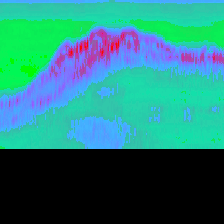

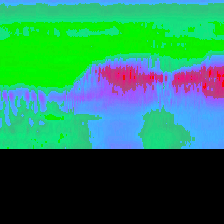

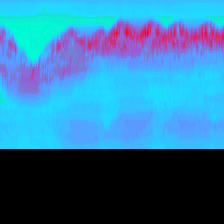

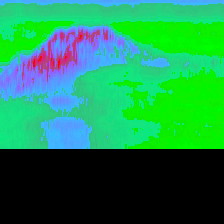

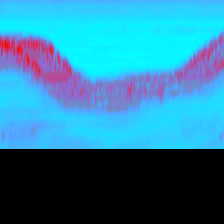

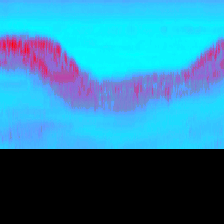

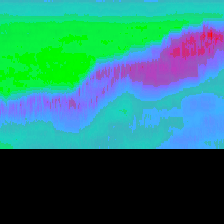

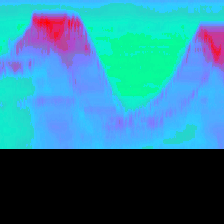

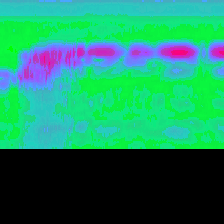

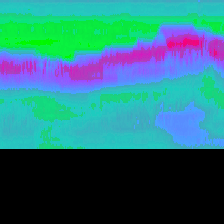

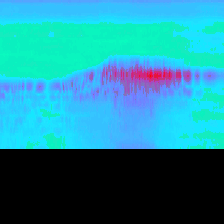

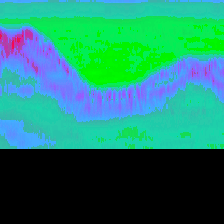

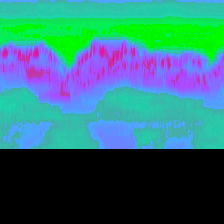

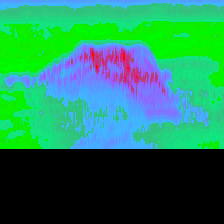

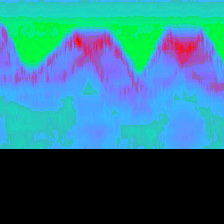

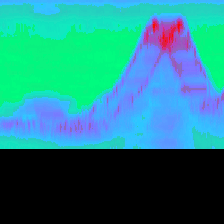

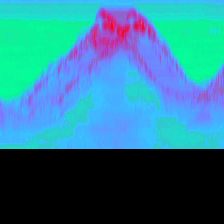

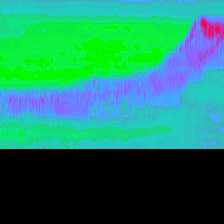

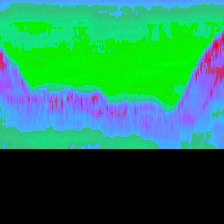

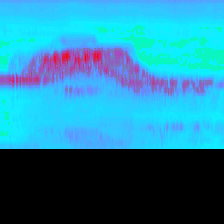

In [ ]:
import glob
import random
from PIL import Image, ImageOps
import albumentations as A
import numpy as np

files = glob.glob("signal/**/*.png", recursive=True)

augment = A.Compose([
    # A.HorizontalFlip(p=0.5),
    # A.RGBShift(p=0.25),
    # A.ColorJitter(p=0.25)
])


size = 224

for _ in range(20):
    # Test Transformations
    choice = random.choice(files)
    img = Image.open(choice)
    img = ImageOps.contain(img, (size, size), Image.Resampling.LANCZOS).convert("RGB")
    img = ImageOps.autocontrast(img)
    img = Image.fromarray(augment(image=np.array(img))["image"])

    img = ImageOps.pad(img, (size, size), centering=(0,0))

    # img = ImageOps.grayscale(img)

    # img = ImageOps.autocontrast(img)
    display(img)


# Loading Processed Dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="/content/signal/with augment/signal_train_augment_timediff2")

Resolving data files:   0%|          | 0/3045 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-ca3797a7cb0837e3/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
data = dataset["train"].train_test_split(test_size=0.2)

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2436
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 609
    })
})

# Initialize Training
I chose ViT for this as it is one of the state-of-the art models at this time.
The rationale behind choosing the variant finetuned on the imagenet as well was to perhaps harness the benefits of transfer learning. Unfortunately, I was not able to validate this hypothesis as there was not enough time.

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
model_name_or_path = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

labels = data['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)

/usr/local/lib/python3.8/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
labels

['0', '1', '2', '3', '4', '5', '6']

In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
def process_example(example):
    example["image"] = example["image"]
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['label'] = example['label']
    return inputs

In [ ]:
def _transform(example_batch):
    IMG_SIZE = 224
    new_imgs = []
    for img in example_batch:
        image = ImageOps.contain(img, (IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS).convert("RGB")
        image = ImageOps.autocontrast(image)
        image = ImageOps.pad(image, (IMG_SIZE, IMG_SIZE), centering=(0, 0))
        new_imgs.append(image)
    return new_imgs

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in _transform(example_batch['image'])], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

In [ ]:
prepared_data = data.with_transform(transform)

In [ ]:
import torch
import numpy as np
from datasets import load_metric

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


acc = load_metric("accuracy")
f1 = load_metric("f1")

def compute_metrics(p):
    info = {}

    preds = np.argmax(p.predictions, axis=1)
    info["accuracy"] = acc.compute(predictions=preds, references=p.label_ids)["accuracy"]
    info["f1"] = f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"]

    return info


<ipython-input-14-65140206de28>:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  acc = load_metric("accuracy")


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-signal-processing-noimgnet",
  per_device_train_batch_size=64,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  num_train_epochs=20,
  fp16=True,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  warmup_ratio=0.05,
  remove_unused_columns=False,
  push_to_hub=False,
  metric_for_best_model="f1",
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_data["train"],
    eval_dataset=prepared_data["test"],
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2436
  Num Epochs = 20
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 780
  Number of trainable parameters = 85804039


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.989200,0.923124,0.663383,0.647076
2,0.466200,0.715477,0.776683,0.803707
3,0.212000,0.346498,0.888342,0.906060
4,0.095400,0.453226,0.889984,0.905911
5,0.075900,0.325984,0.916256,0.923449
6,0.039200,0.151685,0.967159,0.970403
7,0.036800,0.185925,0.954023,0.954480
8,0.016300,0.078482,0.980296,0.980905
9,0.009100,0.081062,0.983580,0.985442
10,0.025800,0.128656,0.970443,0.971137


***** Running Evaluation *****
  Num examples = 609
  Batch size = 8
Saving model checkpoint to ./vit-signal-processing-noimgnet/checkpoint-39
Configuration saved in ./vit-signal-processing-noimgnet/checkpoint-39/config.json
Model weights saved in ./vit-signal-processing-noimgnet/checkpoint-39/pytorch_model.bin
Image processor saved in ./vit-signal-processing-noimgnet/checkpoint-39/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 609
  Batch size = 8
Saving model checkpoint to ./vit-signal-processing-noimgnet/checkpoint-78
Configuration saved in ./vit-signal-processing-noimgnet/checkpoint-78/config.json
Model weights saved in ./vit-signal-processing-noimgnet/checkpoint-78/pytorch_model.bin
Image processor saved in ./vit-signal-processing-noimgnet/checkpoint-78/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 609
  Batch size = 8
Saving model checkpoint to ./vit-signal-processing-noimgnet/checkpoint-117
Configuration saved in ./vit-signal-

***** train metrics *****
  epoch                    =         20.0
  total_flos               = 3516281883GF
  train_loss               =       0.1238
  train_runtime            =   1:03:29.65
  train_samples_per_second =       12.789
  train_steps_per_second   =        0.205


In [ ]:
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         20.0
  total_flos               = 3516281883GF
  train_loss               =       0.1238
  train_runtime            =   1:03:29.65
  train_samples_per_second =       12.789
  train_steps_per_second   =        0.205


In [ ]:
metrics = trainer.evaluate(prepared_data["test"])

***** Running Evaluation *****
  Num examples = 609
  Batch size = 8


In [ ]:
trainer.log_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       20.0
  eval_accuracy           =     0.9836
  eval_f1                 =     0.9854
  eval_loss               =     0.0811
  eval_runtime            = 0:00:11.29
  eval_samples_per_second =     53.934
  eval_steps_per_second   =      6.819


In [ ]:
# Confusion Matrix
import torch
import torch.nn.functional as F
from sklearn import metrics
import copy
 
y_preds = []
y_trues = []
for index,val_item in enumerate(data["test"]):
     encoding = feature_extractor(_transform([val_item["image"]])[0], return_tensors="pt").to("cuda")
     outputs = model(**encoding)
     y_pred = outputs.logits.argmax(-1)
     y_true = val_item["label"]
     y_preds.append(y_pred)
     y_trues.append(y_true)
    #  print(f"{index} out of {len(data['test'])}")
     

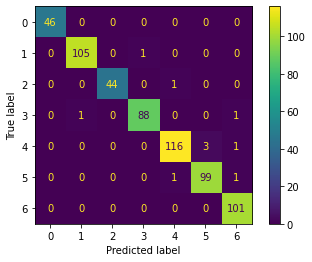

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
cm = metrics.confusion_matrix([int(x) for x in y_trues], [x.item() for x in y_preds], labels=[x for x in range(7)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Get Results
The test files can have many digits in one photo, so we first crop these according to the bounding boxes given.

In [ ]:
test_images = glob.glob("/content/signal/signal_test/*")
test_images

['/content/signal/signal_test/8d1199bd-4e24-460e-9a37-dbdb039f97e0.png',
 '/content/signal/signal_test/995cdebc-3dc5-460e-82db-019b8afa4fad.png',
 '/content/signal/signal_test/357d769e-2148-404e-aa6d-a33b85d2ef9d.png',
 '/content/signal/signal_test/9da3f5bd-5cb2-40b8-b754-b6a331a40d11.png',
 '/content/signal/signal_test/3beacfb6-1686-422a-8606-f7c6d268c8e5.png',
 '/content/signal/signal_test/b080958e-7bcb-49bf-9c76-3a2a2ec30cc5.png',
 '/content/signal/signal_test/ea9f9f74-cad7-4fc8-83d7-147d2e1c0701.png',
 '/content/signal/signal_test/6175a44c-c394-43c1-b4d4-b328c8b051fc.png',
 '/content/signal/signal_test/04079ed6-01e6-42bc-b8a0-b30ea9446bf5.png',
 '/content/signal/signal_test/0d097254-9d9a-4348-bcda-73b534ff27c9.png',
 '/content/signal/signal_test/71def67c-3987-47f8-a337-a559cf0f0560.png',
 '/content/signal/signal_test/93b0f8ec-4c77-490f-af44-0ce78382ca92.png',
 '/content/signal/signal_test/55984454-e39e-43ff-b502-1bf28c469a5f.png',
 '/content/signal/signal_test/5d6553fd-c8c8-480c-92

In [ ]:
from PIL import Image, ImageOps
import torch

answers_final = dict()

with torch.no_grad():
    for img_id, image_path in enumerate(test_images):
        key = image_path.split("/")[-1]

        img = Image.open(image_path)
        
        # Transform those images
        image = ImageOps.contain(img, (224, 224), Image.Resampling.LANCZOS).convert("RGB")
        image = ImageOps.autocontrast(image)
        image = ImageOps.pad(image, (224, 224), centering=(0, 0))

        encoding = feature_extractor(image, return_tensors="pt").to("cuda")
        outputs = model(**encoding)
        pred = outputs.logits.argmax(-1).item()
        answers_final[f"{key.split('.')[0]}"] = model.config.id2label[str(pred)]

answers_final

{'8d1199bd-4e24-460e-9a37-dbdb039f97e0': '6',
 '995cdebc-3dc5-460e-82db-019b8afa4fad': '3',
 '357d769e-2148-404e-aa6d-a33b85d2ef9d': '5',
 '9da3f5bd-5cb2-40b8-b754-b6a331a40d11': '5',
 '3beacfb6-1686-422a-8606-f7c6d268c8e5': '2',
 'b080958e-7bcb-49bf-9c76-3a2a2ec30cc5': '3',
 'ea9f9f74-cad7-4fc8-83d7-147d2e1c0701': '6',
 '6175a44c-c394-43c1-b4d4-b328c8b051fc': '5',
 '04079ed6-01e6-42bc-b8a0-b30ea9446bf5': '4',
 '0d097254-9d9a-4348-bcda-73b534ff27c9': '0',
 '71def67c-3987-47f8-a337-a559cf0f0560': '6',
 '93b0f8ec-4c77-490f-af44-0ce78382ca92': '5',
 '55984454-e39e-43ff-b502-1bf28c469a5f': '1',
 '5d6553fd-c8c8-480c-92d6-13a008884dd7': '5',
 'f839b910-866f-4dad-9d5a-3aecdf9e7744': '6',
 'de5c1f75-ec1c-4ac5-beba-7895bf42d641': '0',
 '3bb8edbc-3367-4be0-8352-4500d55dc726': '4',
 'de58a816-7607-43af-a07d-ff04b34b0ab5': '2',
 '0bf17f5b-f52c-42ef-b771-0187588ad2de': '4',
 'a43d606d-d32a-4c3f-b771-a4c6914e5de0': '1',
 '6ea78645-9f90-4e97-8811-51554e468839': '1',
 '158922c9-ac47-415e-94c2-d9adcfbe

In [ ]:
with open("vit_augment_timediff_bypond-1.csv", "w") as f:
    f.write("id,class\n")
    for name in answers_final:
        f.write(f"{name},{answers_final[name]}\n")